In [494]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.manager import SwarmManager
from backtester.exoinfo import EXOInfo

from sklearn import linear_model, cross_validation, naive_bayes, ensemble, tree, neighbors

import pandas as pd
import numpy as np
import scipy

import glob
from pandas.tseries.offsets import *

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

figsize(20,10)

Populating the interactive namespace from numpy and matplotlib


In [1266]:
df = pd.read_csv('rng_swarm.csv', index_col=[0], parse_dates=[0])

## Rng strategies

In [1344]:
#
# random time series
#
df = pd.DataFrame()
for i in range(1000):
    
    date = pd.date_range(start='2015-01', end='2016-10', freq='D')
    price = np.random.randint(-100, 101, size=len(date))
    
    ser = pd.Series(price, index=date, name='rng_system'+str(i))
    df['rng_system'+str(i)] = ser.cumsum()
   
prefilter_df = df

In [1345]:
df.to_csv('rng_swarm.csv')

## Select input DF. Real swarms or RNG pseudo strategies

In [1468]:
# Real swarms
#df = campaign_portfolio

# Rng strategies
#df = df

# Real swarms from csv
#df = pd.read_csv('./swarms_df/ma_cross_swarm_new.csv', parse_dates=[0],
#                dayfirst=True, index_col=0).asfreq(BDay())

# set file name here
swarm_file = 'GCE_CallSpread_SwingPoint_Long_bearish_failure_Aggresive_Long (Small SPL)'

# Real swarm from .swm
df = SwarmManager.load('./temp_swarms/'+swarm_file+'.swm')
df = df.swarm
#df = df.ix['2015':'2015-05']

In [1469]:
multiple_swarms_df = pd.concat([multiple_swarms_df,df], axis=1)

In [1470]:
multiple_swarms_df

,"(-1, 5, 1, 0.05, 1, 0, 10)","(-1, 5, 1, 0.05, 1, 0, 11)","(-1, 5, 1, 0.05, 1, 0, 12)","(-1, 5, 1, 0.05, 1, 0, 13)","(-1, 5, 1, 0.05, 1, 0, 14)","(-1, 5, 1, 0.05, 1, 0, 15)","(-1, 5, 1, 0.05, 1, 0, 16)","(-1, 5, 1, 0.05, 1, 0, 17)","(-1, 5, 1, 0.05, 1, 0, 18)","(-1, 5, 1, 0.05, 1, 0, 19)",...,"(1, 9, 2, 1, 19)","(1, 9, 2, 1, 2)","(1, 9, 2, 1, 20)","(1, 9, 2, 1, 3)","(1, 9, 2, 1, 4)","(1, 9, 2, 1, 5)","(1, 9, 2, 1, 6)","(1, 9, 2, 1, 7)","(1, 9, 2, 1, 8)","(1, 9, 2, 1, 9)"
2011-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1503]:
df = multiple_swarms_df

In [358]:
swarm = SwarmManager.load('./temp_swarms/'+swarm_file+'.swm')

KeyboardInterrupt: 

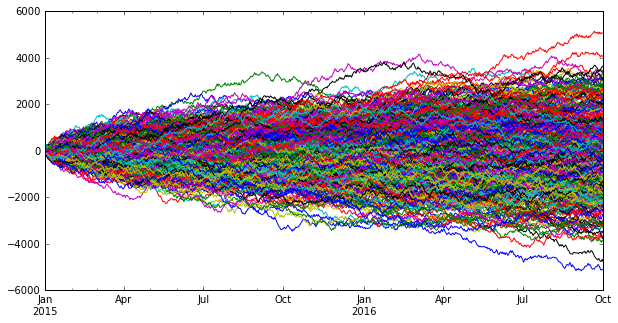

In [1169]:
df.plot(legend=False)

## Systems overall performance estimation

In [1504]:
temp_l = []

for strat in df.columns:

        input_strategy_data = df[strat] # This data is used in metrics calc

        price_change = input_strategy_data.diff()
        max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
        netprofit = df[strat].ix[-1] - df[strat].ix[0]

        # Since swarm PnL statistics is not trade-by-trade
        # For PF calc I used cumulative values of positive and negatives price changes
        # Same for winrate
        profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

        winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

        try:
            modsharpe = np.mean(price_change) / np.std(price_change)

        except ZeroDivisionError:
            modsharpe = np.nan

        d = {'strategy': strat,
            'stats_pricechange_modsharpe': modsharpe, 
            #'stats_netprofit': netprofit,
            #'stats_max_dd': max_dd, 
            'stats_recovery_factor': netprofit / np.abs(max_dd),
            'stats_profit_factor': profit_factor
             }
             #'stats_winrate': winrate }

        temp_l.append(d)

In [1505]:
strategies_performance_df = pd.DataFrame(temp_l).dropna()
strategies_performance_df['rating'] = np.zeros_like(len(strategies_performance_df))

In [1506]:
strategies_performance_df.set_index('strategy', inplace=True)

# Rating
# Proceed to the next block if you already have a dataset 

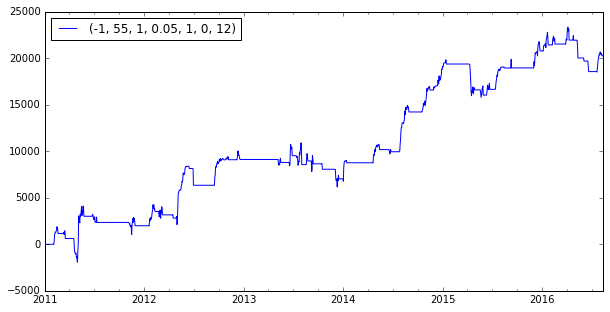

In [1422]:
figsize(10,5)
#print(strategies_performance_df.sample())
sample = strategies_performance_df.sample()
df[sample.index].plot()

In [1031]:
rating = input('Rate this equity from 1 to 5 -- ')

while True:
    
    try:
        if (int(rating) > 0 and int(rating) <= 5):
            strategies_performance_df.loc[strategies_performance_df.index.isin(sample.index), 'rating'] = int(rating)
            break
        else:
            print('Invalid value!')
            rating = input('Rate this equity from 1 to 5 -- ')
            
    except:
        print('Invalid value!')
        rating = input('Rate this equity from 1 to 5 -- ')

Rate this equity from 1 to 5 -- 1


In [967]:
print(strategies_performance_df[strategies_performance_df.rating != 0].drop('rating', 1).shape)
strategies_performance_df[strategies_performance_df.rating != 0]

(0, 3)


,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,rating
strategy,,,,


In [960]:
# uncomment to save a dataset
#strategies_performance_df[strategies_performance_df.rating != 0].to_csv('dataset.csv')

# Model

In [1507]:
dataset = pd.read_csv('dataset.csv', index_col=[0])
train_features = dataset.drop('rating', 1)
train_target = dataset.rating

test_features = strategies_performance_df[strategies_performance_df.rating == 0].drop('rating', 1)

In [1508]:
#model = linear_model.LogisticRegressionCV(Cs=[0.01,0.1,1,10])
#model = linear_model.LogisticRegressionCV(Cs=[10])
#model = neighbors.KNeighborsClassifier(n_neighbors=5)
#model = naive_bayes.GaussianNB()
#model = tree.DecisionTreeClassifier(max_depth=300)
#model = ensemble.RandomForestClassifier(max_depth=3)


logreg = linear_model.LogisticRegressionCV(Cs=[10])
knn = neighbors.KNeighborsClassifier(n_neighbors=7)
gausnb = naive_bayes.GaussianNB()
dt = tree.DecisionTreeClassifier(max_depth=5)
randforest = ensemble.RandomForestClassifier(max_depth=3)

model = ensemble.VotingClassifier(estimators=[('logreg',logreg), ('knn',knn), 
                                              ('gausnb',gausnb), ('dt',dt), ('randforest',randforest)])

model.fit(train_features, train_target)

VotingClassifier(estimators=[('logreg', LogisticRegressionCV(Cs=[10], class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, v...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         voting='hard', weights=None)

In [1509]:
model.score(train_features, train_target)

0.70930232558139539

In [1510]:
#model.feature_importances_

In [1511]:
cross_validation.cross_val_score(model, train_features, train_target, cv=10).mean()

0.63383477633477625

In [1512]:
strategies_performance_df.loc[strategies_performance_df.rating != None , 'rating'] = model.predict(test_features)

ValueError: setting an array element with a sequence.

In [1502]:
test_features.stats_pricechange_modsharpe.plot()

TypeError: Empty 'DataFrame': no numeric data to plot

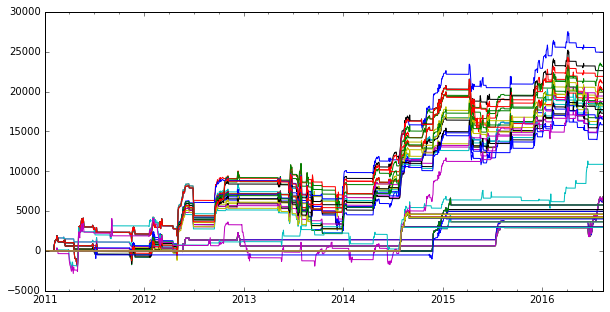

In [1430]:
df[strategies_performance_df[strategies_performance_df.rating == 5].index].plot(legend=False)

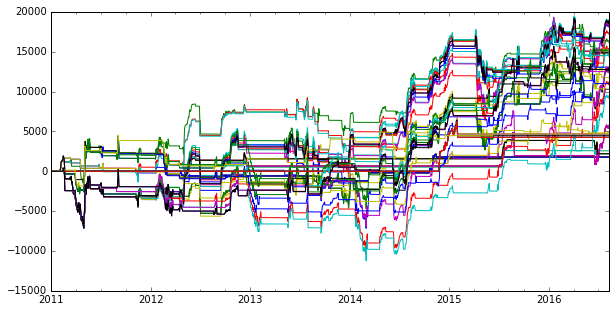

In [1431]:
df[strategies_performance_df[strategies_performance_df.rating == 4].index].plot(legend=False)

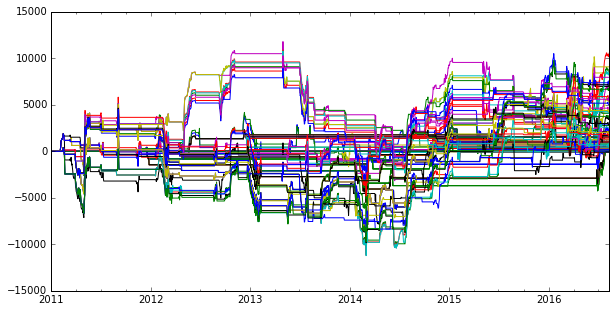

In [1432]:
df[strategies_performance_df[strategies_performance_df.rating == 3].index].plot(legend=False)

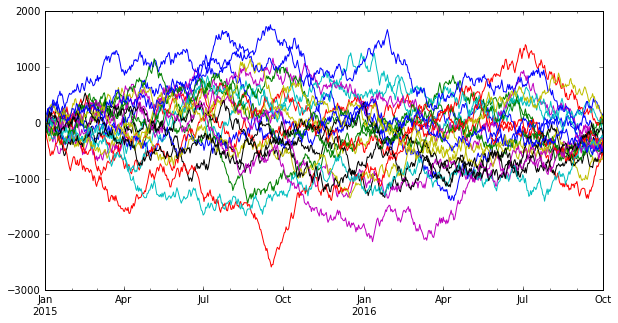

In [1066]:
df[strategies_performance_df[strategies_performance_df.rating == 2].index].plot(legend=False)

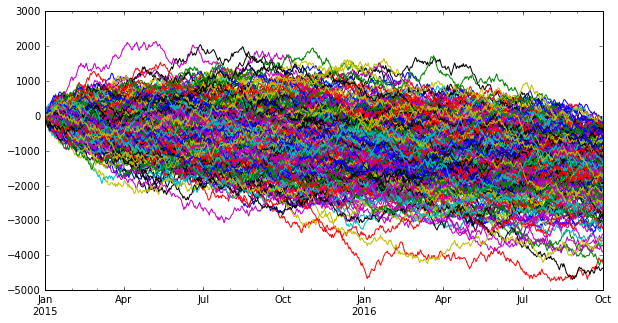

In [1087]:
df[strategies_performance_df[strategies_performance_df.rating == 1].index].plot(legend=False)

# Rating and performance metrics dependencies

## X - Predicted rating
## Y - Performance metrics(1 - mod.sharpe, 2 - profit factor, 3 - recovery factor)

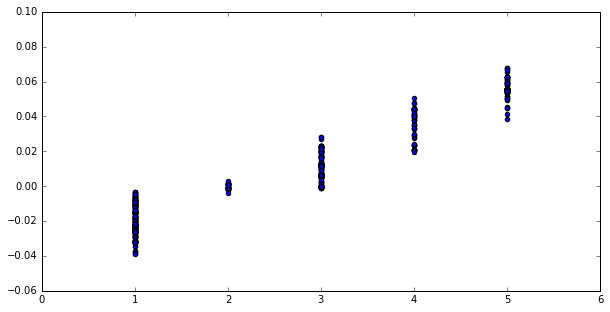

In [1433]:
scatter(strategies_performance_df.rating, strategies_performance_df.stats_pricechange_modsharpe)

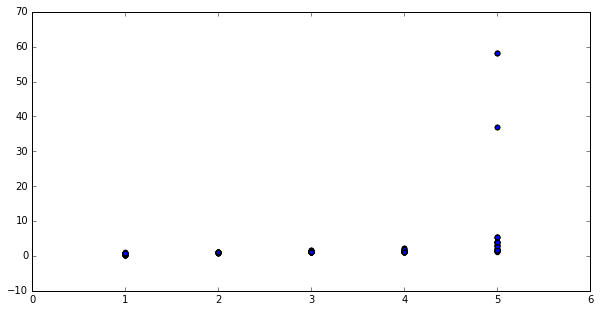

In [1434]:
scatter(strategies_performance_df.rating, strategies_performance_df.stats_profit_factor)

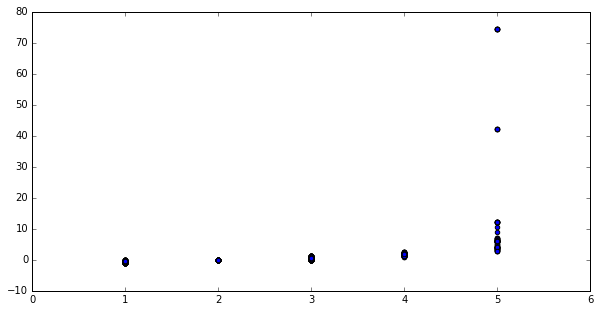

In [1435]:
scatter(strategies_performance_df.rating, strategies_performance_df.stats_recovery_factor)

## Strategies overall performance ranking

In [1436]:
strategies_performance_df.sort_values('rating', ascending=False)
#strategies_performance_df.sort_values('stats_netprofit', ascending=False)

,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,rating
strategy,,,,
"(-1, 55, 4, 0.05, 1, 6, 9)",0.062378,5.403071,12.073684,5
"(-1, 55, 4, 0.05, 1, 4, 3)",0.055251,58.269231,74.450000,5
"(-1, 55, 1, 0.05, 1, 4, 14)",0.053979,1.908284,3.422520,5
"(-1, 55, 4, 0.05, 1, 4, 10)",0.062378,5.403071,12.073684,5
"(-1, 55, 4, 0.05, 1, 4, 11)",0.049924,2.965009,5.927778,5
"(-1, 55, 4, 0.05, 1, 4, 12)",0.055537,3.877410,6.055072,5
"(-1, 55, 4, 0.05, 1, 4, 13)",0.055537,3.877410,6.055072,5
"(-1, 55, 4, 0.05, 1, 4, 14)",0.055537,3.877410,6.055072,5
"(-1, 55, 4, 0.05, 1, 4, 15)",0.055537,3.877410,6.055072,5


## Drop all strategies which have rank score less than n quantile value 

In [1437]:
df = df[strategies_performance_df[strategies_performance_df.rating == 5].index]

KeyboardInterrupt: 

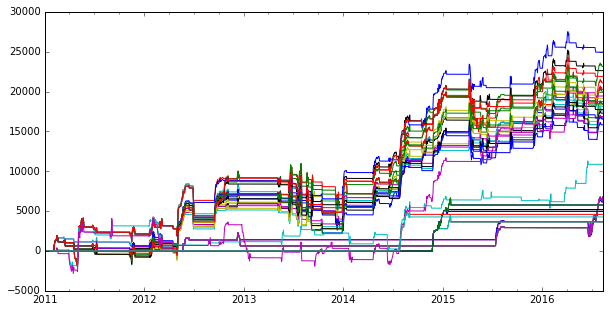

In [1438]:
df.dropna().plot(legend=False)

## Filter those strategies by correlation

In [1439]:
# Rearrange columns from best to worst strategies
df = df.reindex_axis(strategies_performance_df.sort_values('rating', ascending=False).index, axis=1).dropna(axis=1).asfreq(BDay())

In [1440]:
df

strategy,"(-1, 55, 4, 0.05, 1, 6, 9)","(-1, 55, 4, 0.05, 1, 4, 3)","(-1, 55, 1, 0.05, 1, 4, 14)","(-1, 55, 4, 0.05, 1, 4, 10)","(-1, 55, 4, 0.05, 1, 4, 11)","(-1, 55, 4, 0.05, 1, 4, 12)","(-1, 55, 4, 0.05, 1, 4, 13)","(-1, 55, 4, 0.05, 1, 4, 14)","(-1, 55, 4, 0.05, 1, 4, 15)","(-1, 55, 4, 0.05, 1, 4, 16)",...,"(-1, 55, 4, 0.05, 1, 6, 20)","(-1, 55, 4, 0.05, 1, 6, 2)","(-1, 55, 4, 0.05, 1, 6, 19)","(-1, 55, 4, 0.05, 1, 6, 15)","(-1, 55, 4, 0.05, 1, 6, 6)","(-1, 55, 4, 0.05, 1, 6, 16)","(-1, 55, 4, 0.05, 1, 6, 17)","(-1, 55, 4, 0.05, 1, 6, 14)","(-1, 55, 4, 0.05, 1, 6, 8)","(-1, 55, 4, 0.05, 1, 6, 7)"
2011-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1441]:
corr_df = df.corr()

while_loop_break_flag = False

while True:   
    if while_loop_break_flag == False:
        
        for i in range(len(corr_df)):

            try:       
                strat_corr = corr_df[corr_df.columns[i]]
            
            except IndexError:               
                strat_corr = corr_df[corr_df.columns[-1]]
            
            df = df.drop(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.9)].index, axis=1)

            # Check if previous DF are the same as current DF
            # If they are different - continue the loop

            df_comparison_array = np.array_equal(corr_df,df.corr())
            
            #print(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.5)].index)
            #print(i)
            #print(len(corr_df))
            #print(len(corr_df))
            
            if df_comparison_array  == False and i < len(corr_df):
                corr_df = df.corr()

            elif df_comparison_array  == True and i == len(corr_df)-1:
                while_loop_break_flag = True
                break
                    
    if while_loop_break_flag == True:
        break

In [1442]:
df.corr()

strategy,"(-1, 55, 4, 0.05, 1, 6, 9)","(-1, 55, 1, 0.05, 1, 4, 14)","(-1, 55, 1, 0.05, 1, 0, 9)","(-1, 55, 4, 0.05, 1, 5, 6)"
strategy,,,,
"(-1, 55, 4, 0.05, 1, 6, 9)",1.000000,0.682208,0.884427,0.871431
"(-1, 55, 1, 0.05, 1, 4, 14)",0.682208,1.000000,0.821995,0.713993
"(-1, 55, 1, 0.05, 1, 0, 9)",0.884427,0.821995,1.000000,0.805265
"(-1, 55, 4, 0.05, 1, 5, 6)",0.871431,0.713993,0.805265,1.000000


# Metrics calculation

In [1443]:
#
# Rebalance triggers
#
# Rebalance trigger must be array of Datetime indexes when event occurred, like date of monday or new month
# 
newmonth = df[df.index.month != df.index.shift(1).month].index

monday = df[df.index.weekday == 0].index

norebalance = [df.index[-1]]

newyear = df[df.index.year != df.index.shift(1).year].index
#
#
#

# note: I think more performance metrics for strategies is better
# https://www.amibroker.com/guide/h_report.html for reference

rebalance_index = 1
rebalance_date_start = None

rebalance_trigger = monday # set rebalance trigger here

temp_l = []

for reb_idx in rebalance_trigger:
    
    for strat in df.columns:

        if rebalance_index == 1:
            rebalance_date_start = df.index[0]
           
        for i in range(len(df[strat])):

            if df[strat].index[i] == reb_idx:

                input_strategy_data = df[strat].ix[rebalance_date_start:reb_idx] # This data is used in metrics calc
                
                price_change = input_strategy_data.diff()
                max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
                netprofit = df[strat].ix[reb_idx] - df[strat].ix[rebalance_date_start]
                
                # Since swarm PnL statistics is not trade-by-trade
                # For PF calc I used cumulative values of positive and negatives price changes
                # Same for winrate
                profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())
                
                winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               
                # If all trades are negative, PF is 0. But later all 0s is replaced with NaN. 
                # To avoid replacing true 0.0 PF set it to 0.000001
                # This made for handling missing data 
                
                # Also winrate can be 0.0, but if PF is NaN - no trades were made
                # This made for handling missing data 
                
                if winrate == 0.0 and np.isnan(profit_factor) == False:
                    winrate = 0.000001
                
                elif winrate == 0.0 and np.isnan(profit_factor) == True:
                    winrate = np.nan
                                
                if profit_factor == 0.0:
                    profit_factor = 0.000001                
                          
                try:
                    modsharpe = np.mean(price_change) / np.std(price_change)
                    
                except ZeroDivisionError:
                    modsharpe = np.nan
            
                
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_netprofit': netprofit,
                    'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
                    'stats_profit_factor': profit_factor, 'stats_winrate': winrate, 
                     'equity_below_zero': df[strat].ix[reb_idx] < 0}
                
                '''
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_recovery_factor': netprofit / np.abs(max_dd)}
                '''
                
                temp_l.append(d)
    
    rebalance_index += 1
    rebalance_date_start = reb_idx # set new start rebalance date to current rebalance trigger date

### Data cleaning

In [1444]:
# Replacing 0 values with NaNs
# If strategy stats is 0 means that no trades were made
stats_df = pd.DataFrame(temp_l).replace(0, np.nan)

# Filling NaNs with last avaible values
for s in stats_df.strategy.unique():
    stats_df[stats_df.strategy == s] = stats_df[stats_df.strategy == s].fillna(method='pad')

stats_df = stats_df.dropna(how='any')

In [1445]:
stats_df

,equity_below_zero,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy
22,False,2011-02-07,2011-01-31,6,-12.0,1078.0,0.782241,90.833333,89.833333,40.000000,"(-1, 55, 1, 0.05, 1, 0, 9)"
26,False,2011-02-14,2011-02-07,7,-10.0,410.0,1.386846,42.000000,41.000000,80.000000,"(-1, 55, 1, 0.05, 1, 0, 9)"
30,False,2011-02-21,2011-02-14,8,-720.0,-320.0,-0.228304,0.555556,-0.444444,20.000000,"(-1, 55, 1, 0.05, 1, 0, 9)"
34,False,2011-02-28,2011-02-21,9,-720.0,-320.0,-0.228304,0.555556,-0.444444,20.000000,"(-1, 55, 1, 0.05, 1, 0, 9)"
38,False,2011-03-07,2011-02-28,10,-720.0,-320.0,-0.228304,0.555556,-0.444444,20.000000,"(-1, 55, 1, 0.05, 1, 0, 9)"
42,False,2011-03-14,2011-03-07,11,-230.0,-122.0,-0.210678,0.515873,-0.530435,20.000000,"(-1, 55, 1, 0.05, 1, 0, 9)"
46,False,2011-03-21,2011-03-14,12,-230.0,-122.0,-0.210678,0.515873,-0.530435,20.000000,"(-1, 55, 1, 0.05, 1, 0, 9)"
50,False,2011-03-28,2011-03-21,13,-230.0,-122.0,-0.210678,0.515873,-0.530435,20.000000,"(-1, 55, 1, 0.05, 1, 0, 9)"
54,False,2011-04-04,2011-03-28,14,-230.0,-122.0,-0.210678,0.515873,-0.530435,20.000000,"(-1, 55, 1, 0.05, 1, 0, 9)"
58,False,2011-04-11,2011-04-04,15,-230.0,-122.0,-0.210678,0.515873,-0.530435,20.000000,"(-1, 55, 1, 0.05, 1, 0, 9)"


## Statistics rank calculation

In [1446]:
ranks_d = {}
ranks_rebidx_d = {}

for i in stats_df.rebalance_index.unique():

    for col in stats_df[stats_df.rebalance_index == i].columns:
        
        stats_col_flag = False
    
        if 'stats' in col:

            # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
            metric_quantile0 = stats_df[stats_df.rebalance_index == i][col].quantile(0.0)
            metric_quantile10 = stats_df[stats_df.rebalance_index == i][col].quantile(0.1)
            metric_quantile20 = stats_df[stats_df.rebalance_index == i][col].quantile(0.2)
            metric_quantile30 = stats_df[stats_df.rebalance_index == i][col].quantile(0.3)
            metric_quantile40 = stats_df[stats_df.rebalance_index == i][col].quantile(0.4)
            metric_quantile50 = stats_df[stats_df.rebalance_index == i][col].quantile(0.5)
            metric_quantile60 = stats_df[stats_df.rebalance_index == i][col].quantile(0.6)
            metric_quantile70 = stats_df[stats_df.rebalance_index == i][col].quantile(0.7)
            metric_quantile80 = stats_df[stats_df.rebalance_index == i][col].quantile(0.8)
            metric_quantile90 = stats_df[stats_df.rebalance_index == i][col].quantile(0.9)
            metric_quantile100 = stats_df[stats_df.rebalance_index == i][col].quantile(1)

            stats_col_flag = True

        if stats_col_flag == True:
    
            for strat in stats_df[stats_df.rebalance_index == i].strategy:

                # Define strategy statistics rank of certain strategy

                strategy_stats_metric = stats_df[(stats_df.rebalance_index == i) 
                                                 & (stats_df.strategy == strat)][col].values[0]

                if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                    rank_score = 0

                elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                    rank_score = 1

                elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                    rank_score = 2

                elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                    rank_score = 3

                elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                    rank_score = 4

                elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                    rank_score = 5

                elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                    rank_score = 6

                elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                    rank_score = 7

                elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                    rank_score = 8

                elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                    rank_score = 9

                elif strategy_stats_metric == metric_quantile100:
                    rank_score = 10

                    
                if strat not in ranks_d.keys():               
                    ranks_d[strat] = rank_score
                    
                elif strat in ranks_d.keys():                
                    ranks_d[strat] = ranks_d[strat] + rank_score
            #ranks_d['rebalance_idx_'+str(i)] = i

                    
                # For debugging purposes

                #print('strategy---',strat,'\n')
                #print(col)
                #print('10 quantile---',metric_quantile10)
                #print(strategy_stats_metric)
                #print('60 quantile---',metric_quantile60)
                #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
                #print('rank_score------', rank_score, '\n')

    
    print('rebalance index ---', i)
    #break
    for k in ranks_d:

        strat_index = stats_df[(stats_df.strategy == k) & ((stats_df.rebalance_index == i))].index
        #print(strat_index)
        stats_df = stats_df.set_value(strat_index, 'rank_score', ranks_d[k])
        
    ranks_d = {}

rebalance index --- 6
rebalance index --- 7
rebalance index --- 8
rebalance index --- 9
rebalance index --- 10
rebalance index --- 11
rebalance index --- 12
rebalance index --- 13
rebalance index --- 14
rebalance index --- 15
rebalance index --- 16
rebalance index --- 17
rebalance index --- 18
rebalance index --- 19
rebalance index --- 20
rebalance index --- 21
rebalance index --- 22
rebalance index --- 23
rebalance index --- 24
rebalance index --- 25
rebalance index --- 26
rebalance index --- 27
rebalance index --- 28
rebalance index --- 29
rebalance index --- 30
rebalance index --- 31
rebalance index --- 32
rebalance index --- 33
rebalance index --- 34
rebalance index --- 35
rebalance index --- 36
rebalance index --- 37
rebalance index --- 38
rebalance index --- 39
rebalance index --- 40
rebalance index --- 41
rebalance index --- 42
rebalance index --- 43
rebalance index --- 44
rebalance index --- 45
rebalance index --- 46
rebalance index --- 47
rebalance index --- 48
rebalance index

### Strategies picker

In [1447]:
# Trade-by-trade pnl
pnl_df = df.diff()

summary_best_eqty = pd.Series()
summary_worst_eqty = pd.Series()
benchmark_eqty = pd.Series()

rebalance_history_l = []

# We can set start rebalance index value to 
for i in range(stats_df.rebalance_index.unique().min(),stats_df.rebalance_index.unique().max()):
    
    if i < 2:
        # We must estimate strategies preformance at least on one rebalance window
        continue
        
    else:

        # Pick strats from previous rebalance, but trade them until next rebalance
                        
        start_date = stats_df[stats_df.rebalance_index == i].rebalance_date_start.values[0]  
        end_date = stats_df[stats_df.rebalance_index == i].rebalance_date_end.values[0]
        
        # Number of picked strats defined by .strategy.values[:number]
        # Remove -1 from 'i - 1' to get holy grail :D (future reference)
        
        picked_best_strats = stats_df[(stats_df.rebalance_index == i - 1) & (stats_df.equity_below_zero == False)].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:2]
        
        picked_worst_strats = stats_df[(stats_df.rebalance_index == i - 1) & (stats_df.equity_below_zero == False)].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[-2:]
        
        all_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:]
        
        if len(summary_best_eqty) == 0 and len(summary_worst_eqty) == 0 and len(benchmark_eqty) == 0:
            summary_best_eqty = pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1)           
            summary_worst_eqty = pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1)
            
            benchmark_eqty = pnl_df[all_strats].ix[start_date : end_date].sum(axis=1)      
            
        else:
            summary_best_eqty = summary_best_eqty.append(pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1))
            summary_worst_eqty = summary_worst_eqty.append(pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1))
            
            benchmark_eqty = benchmark_eqty.append(pnl_df[all_strats].ix[start_date : end_date].sum(axis=1))
        
        d = {'rebalance_index': i, 'best_strategies_list': picked_best_strats}
        
        for s in range(len(picked_best_strats)):
            d['strategy_'+str(s)] = picked_best_strats[s]
        
        rebalance_history_l.append(d)
        
        
best_portfolio = summary_best_eqty.cumsum()
worst_portfolio = summary_worst_eqty.cumsum() * -1 # Reversed

summary_portfolio = best_portfolio + worst_portfolio

benchmark_portfolio = benchmark_eqty.cumsum()

## Rebalance history


In [1448]:
rebalance_history_df = pd.DataFrame(rebalance_history_l)
rebalance_history_df.index = rebalance_history_df.rebalance_index


same_strats_counter = 0
different_strats_counter = 0

same_strats_counter_l = []
different_strats_counter_l = []

for i in rebalance_history_df.index:
    
    if i > rebalance_history_df.index[0]+1:
        
        for c in rebalance_history_df.columns:
            
            if 'strategy' in c:
                
                if rebalance_history_df[c][i] in rebalance_history_df.best_strategies_list[i-1]:
                    same_strats_counter += 1
                
                if rebalance_history_df[c][i] not in rebalance_history_df.best_strategies_list[i-1]:
                    different_strats_counter += 1
    
    same_strats_counter_l.append(same_strats_counter)
    different_strats_counter_l.append(different_strats_counter)
    
    same_strats_counter = 0
    different_strats_counter = 0

rebalance_history_df['same_strategies'] = same_strats_counter_l
rebalance_history_df['different_strategies'] = different_strats_counter_l
rebalance_history_df = rebalance_history_df.fillna('No_Strategy')

In [1449]:
#stats_df[(stats_df.rebalance_index >= 5) & (stats_df.rebalance_index <= 22)]
stats_df[(stats_df.rebalance_index == 100)]

,equity_below_zero,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
397,False,2012-11-26,2012-11-19,100,-260.0,-260.0,-0.500000,0.000001,-1.0,0.000001,"(-1, 55, 1, 0.05, 1, 4, 14)",22.0
398,False,2012-11-26,2012-11-19,100,-330.0,-330.0,-0.500000,0.000001,-1.0,0.000001,"(-1, 55, 1, 0.05, 1, 0, 9)",14.0
399,True,2012-11-26,2012-11-19,100,-920.0,-920.0,-0.780165,0.000001,-1.0,0.000001,"(-1, 55, 4, 0.05, 1, 5, 6)",0.0


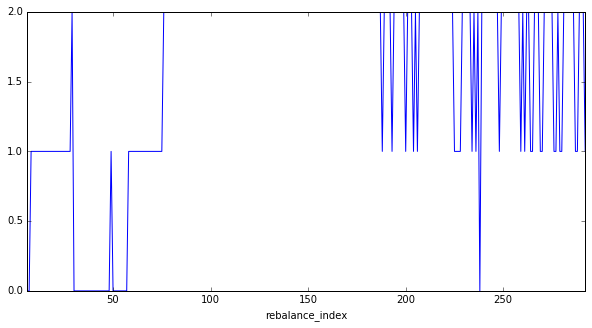

In [1450]:
rebalance_history_df.same_strategies.plot()

In [1451]:
rebalance_history_df.same_strategies[rebalance_history_df.same_strategies == 0].count() / rebalance_history_df.same_strategies.count()

0.10452961672473868

In [1452]:
rebalance_history_df.same_strategies[rebalance_history_df.same_strategies == 1].count() / rebalance_history_df.same_strategies.count()

0.2264808362369338

In [1453]:
rebalance_history_df.same_strategies[rebalance_history_df.same_strategies == 2].count() / rebalance_history_df.same_strategies.count()

0.66898954703832758

In [1454]:
rebalance_history_df.same_strategies[rebalance_history_df.same_strategies == 3].count() / rebalance_history_df.same_strategies.count()

0.0

## Comparing portfolios stats with benchmark(all strategies equity)

In [1455]:
def portfolio_stats(portfolio_ser,label):
    input_data = portfolio_ser # This data is used in metrics calc
                
    price_change = input_data.diff()
    max_dd = (input_data - input_data.expanding().max()).min()
    netprofit = input_data.ix[input_data.index[-1]] - input_data.ix[input_data.index[0]]

    # Since swarm PnL statistics is not trade-by-trade
    # For PF calc I used cumulative values of positive and negatives price changes
    # Same for winrate
    profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

    winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

    modsharpe = np.mean(price_change) / np.std(price_change)

    recovery_factor = netprofit / np.abs(max_dd)

    print('Portfolio name ---', str(label))
    print('\n')
    print('PriceChange Mod. Sharpe', modsharpe)
    print('Netprofit',netprofit)
    print('Max DD', max_dd)
    print('Recovery Factor', recovery_factor)
    print('Profit factor', profit_factor)
    print('Winrate', winrate)

    input_data.plot(kind='area', stacked=False)

Portfolio name --- Best


PriceChange Mod. Sharpe 0.10309203016883545
Netprofit 45862.0
Max DD -6436.0
Recovery Factor 7.12585456805
Profit factor 1.76607757325
Winrate 17.6060429983


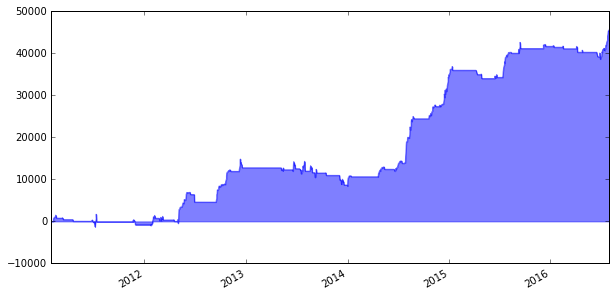

In [1456]:
portfolio_stats(best_portfolio, 'Best')

Portfolio name --- Worst(reversed)


PriceChange Mod. Sharpe -0.05384557745774593
Netprofit -19864.0
Max DD -23736.0
Recovery Factor -0.836872261544
Profit factor 0.718153182553
Winrate 10.517141197


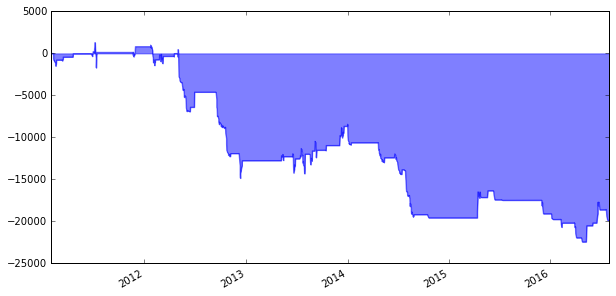

In [1457]:
portfolio_stats(worst_portfolio, 'Worst(reversed)')

Portfolio name --- Summary(Best + Worst)


PriceChange Mod. Sharpe 0.08298625071360675
Netprofit 25998.0
Max DD -7316.0
Recovery Factor 3.55358119191
Profit factor 1.85250524659
Winrate 9.35502614759


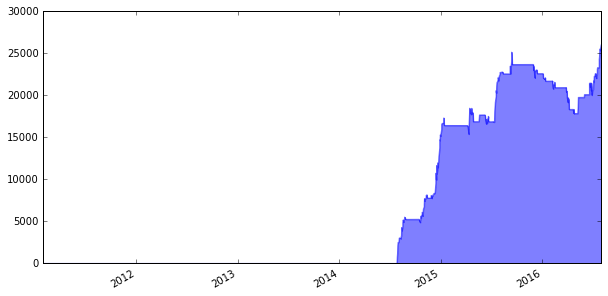

In [1458]:
portfolio_stats(summary_portfolio, 'Summary(Best + Worst)')

Portfolio name --- Benchmark(Trade all strategies)


PriceChange Mod. Sharpe 0.10247470143100541
Netprofit 50352.0
Max DD -6754.0
Recovery Factor 7.45513769618
Profit factor 1.67688336829
Winrate 19.930273097


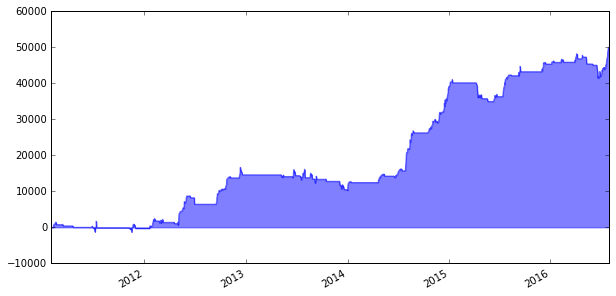

In [1459]:
portfolio_stats(benchmark_portfolio, 'Benchmark(Trade all strategies)')

In [1460]:
portfolio_stats(swarm.swarm_picked.sum(axis=1), 'Picked swarm with current approach')

NameError: name 'swarm' is not defined

In [35]:
portfolio_stats(all_equities_sum, 'All equities')

NameError: name 'all_equities_sum' is not defined

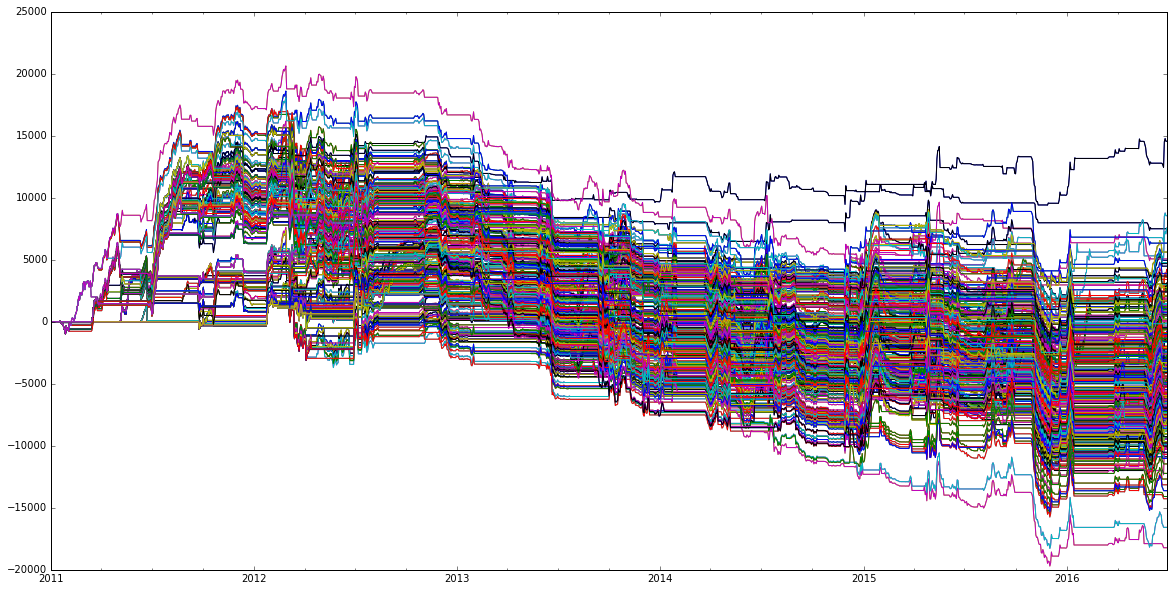

In [250]:
swarm.swarm.plot(legend=False)